In [1]:
import h5py
import nibabel as nib
import numpy as np
import os
import math
from PIL import Image
from skimage import measure
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [2]:
#volumeDirs = ["Datasets/RawData/TrainingData/Volumes/", "Datasets/RawData/ValidationData/Volumes/", "Datasets/RawData/TestingData/Volumes/"]
#segmentationDirs = ["Datasets/RawData/TrainingData/Segmentations/", "Datasets/RawData/ValidationData/Segmentations/", "Datasets/RawData/TestingData/Segmentations/"]

volumeDirs = ["Datasets/RawData/TestVol/"]
segmentationDirs = ["Datasets/RawData/TestSeg/"]

fileNames = ["MultiClassTestingDataset.hdf5"]

numFiles = []

for fileName in volumeDirs:
    numFiles.append(len([name for name in os.listdir(fileName) if os.path.isfile(os.path.join(fileName, name))]))

#Percent of slices to keep from each scan, starts from middle of array
keepRate = 0.3

#Resize all slices/segmentations to imageDim x imageDim
imageDim = 256

In [ ]:
def window_level(vol, window_center, window_width): 
    img_min = window_center - window_width // 2 
    img_max = window_center + window_width // 2 
    window_image = vol.copy() 
    window_image[window_image < img_min] = img_min 
    window_image[window_image > img_max] = img_max 

    return window_image 

In [ ]:
minVal = float('inf')
maxVal = float('-inf')

for volumeDir in volumeDirs:
    for i, name in enumerate(os.listdir(volumeDir)):
        #Disregards hidden files
        if name[0] == '.':
            continue

        ctScan = nib.load(volumeDir + name)
        volumeData = ctScan.get_fdata()

        minVal = min(np.amin(volumeData), minVal)
        maxVal = max(np.amax(volumeData), maxVal)

# **Standard Datasets**

In [ ]:
#Binary LiTS
livers = []
total = []

for i in range(len(volumeDirs)):
    volumeDir = volumeDirs[i]
    segmentationDir = segmentationDirs[i]

    numLivers = 0
    totalSlices = 0

    file = h5py.File(fileNames[i], "w")

    sliceNum = 0

    for i, name in enumerate(os.listdir(volumeDir)):
        #Disregards hidden files
        if name[0] == '.':
            continue

        #Loads segmentation and volume data from .nii file
        ctScan = nib.load(volumeDir + name)
        volumeData = ctScan.get_fdata()

        volumeData = window_level(volumeData, 40, 400)

        segmentation = nib.load(segmentationDir + os.listdir(segmentationDir)[i])
        segmentData = segmentation.get_fdata()

        #Loops through all usable slices and adds data to h5 file
        #Finds middle index, subtracts half * keepRate from it, goes to middle index + half * keepRate
        for plane in range(math.ceil(((volumeData.shape[2] - 1) / 2) - (((volumeData.shape[2] - 1) / 2) * keepRate)), 
        math.floor(((volumeData.shape[2] - 1) / 2) + (((volumeData.shape[2] - 1) / 2) * keepRate))):

            volumeSlice = np.array(Image.fromarray(volumeData[:,:,plane].astype(np.int16)).resize((imageDim, imageDim), Image.BILINEAR))
            segmentSlice = segmentData[:,:,plane].astype(np.int16)

            volumeSlice = volumeSlice.astype(np.float16)

            volumeSlice -= minVal
            volumeSlice /= maxVal - minVal

            #Gets max value of current segmenation, limits it to 1 (1 if contains liver, 0 if not)
            label = min(np.amax(segmentSlice), 1)
            segmentSlice = np.array(Image.fromarray(segmentSlice).resize((imageDim, imageDim), Image.NEAREST))

            numLivers += label
            totalSlices += 1

            #Creates subgroup for current slice in current scan, adds slice/segmentation/label data
            currSlice = file.create_group("Slice" + str(sliceNum))
            currSlice.create_dataset("Slice", data=volumeSlice)
            currSlice.create_dataset("Segmentation", data=segmentSlice)
            currSlice.attrs.create("ImageLabel", label, (1,), "int")

            sliceNum += 1

    livers.append(numLivers)
    total.append(totalSlices)

print(f"Liver Present: {livers} Total: {total}")

file.close()

In [ ]:
#Multiclass LiTS
livers = []
total = []

for i in range(len(volumeDirs)):
    volumeDir = volumeDirs[i]
    segmentationDir = segmentationDirs[i]

    numLivers = 0
    totalSlices = 0

    file = h5py.File(fileNames[i], "w")

    sliceNum = 0

    for i, name in enumerate(os.listdir(volumeDir)):
        #Disregards hidden files
        if name[0] == '.':
            continue

        #Loads segmentation and volume data from .nii file
        ctScan = nib.load(volumeDir + name)
        volumeData = ctScan.get_fdata()

        volumeData = window_level(volumeData, 40, 400)

        segmentation = nib.load(segmentationDir + os.listdir(segmentationDir)[i])
        segmentData = segmentation.get_fdata()

        #Loops through all usable slices and adds data to h5 file
        #Finds middle index, subtracts half * keepRate from it, goes to middle index + half * keepRate
        for plane in range(math.ceil(((volumeData.shape[2] - 1) / 2) - (((volumeData.shape[2] - 1) / 2) * keepRate)), 
        math.floor(((volumeData.shape[2] - 1) / 2) + (((volumeData.shape[2] - 1) / 2) * keepRate))):

            volumeSlice = np.array(Image.fromarray(volumeData[:,:,plane].astype(np.int16)).resize((imageDim, imageDim), Image.BILINEAR))
            segmentSlice = segmentData[:,:,plane].astype(np.int16)

            volumeSlice = volumeSlice.astype(np.float16)

            volumeSlice -= minVal
            volumeSlice /= maxVal - minVal

            #Gets max value of current segmenation, limits it to 1 (1 if contains liver, 0 if not)
            label = min(np.amax(segmentSlice), 1)
            segmentSlice = np.array(Image.fromarray(segmentSlice).resize((imageDim, imageDim), Image.NEAREST))
            liverSegment = (segmentSlice == 1).astype(int)
            tumorSegment = (segmentSlice == 2).astype(int)

            numLivers += label
            totalSlices += 1

            #Creates subgroup for current slice in current scan, adds slice/segmentation/label data
            currSlice = file.create_group("Slice" + str(sliceNum))
            currSlice.create_dataset("Slice", data=volumeSlice)
            currSlice.create_dataset("LiverSegmentation", data=liverSegment)
            currSlice.create_dataset("TumorSegmentation", data=tumorSegment)
            currSlice.attrs.create("ImageLabel", label, (1,), "int")

            sliceNum += 1

    livers.append(numLivers)
    total.append(totalSlices)

print(f"Liver Present: {livers} Total: {total}")

file.close()

In [ ]:
livers = []
total = []

fileName = "ReducedDataFineTuneDataset"
volumeDir = "Datasets/RawData/TrainingData/Volumes/"
segmentationDir = "Datasets/RawData/TrainingData/Segmentations/"
for numScans in range(len(os.listdir(volumeDir))):
    numLivers = 0
    totalSlices = 0

    file = h5py.File(fileName + str(numScans + 1) + "Scans", "w")

    sliceNum = 0

    for i, name in enumerate(os.listdir(volumeDir)):
        if i > numScans:
            break
        
        #Disregards hidden files
        if name[0] == '.':
            continue

        #Loads segmentation and volume data from .nii file
        ctScan = nib.load(volumeDir + name)
        volumeData = ctScan.get_fdata()

        volumeData = window_level(volumeData, 40, 400)

        segmentation = nib.load(segmentationDir + os.listdir(segmentationDir)[i])
        segmentData = segmentation.get_fdata()

        #Loops through all usable slices and adds data to h5 file
        #Finds middle index, subtracts half * keepRate from it, goes to middle index + half * keepRate
        for plane in range(math.ceil(((volumeData.shape[2] - 1) / 2) - (((volumeData.shape[2] - 1) / 2) * keepRate)), 
        math.floor(((volumeData.shape[2] - 1) / 2) + (((volumeData.shape[2] - 1) / 2) * keepRate))):

            volumeSlice = np.array(Image.fromarray(volumeData[:,:,plane].astype(np.int16)).resize((imageDim, imageDim), Image.BILINEAR))
            segmentSlice = segmentData[:,:,plane].astype(np.int16)

            volumeSlice = volumeSlice.astype(np.float16)

            volumeSlice -= minVal
            volumeSlice /= maxVal - minVal

            #Gets max value of current segmenation, limits it to 1 (1 if contains liver, 0 if not)
            label = min(np.amax(segmentSlice), 1)
            segmentSlice = np.array(Image.fromarray(segmentSlice).resize((imageDim, imageDim), Image.NEAREST))

            numLivers += label
            totalSlices += 1

            #Creates subgroup for current slice in current scan, adds slice/segmentation/label data
            currSlice = file.create_group("Slice" + str(sliceNum))
            currSlice.create_dataset("Slice", data=volumeSlice)
            currSlice.create_dataset("Segmentation", data=segmentSlice)
            currSlice.attrs.create("ImageLabel", label, (1,), "int")

            sliceNum += 1
        
        livers.append(numLivers)
        total.append(totalSlices)

print(f"Liver Present: {livers} Total: {total}")
file.close()

In [ ]:
for fileName in fileNames:
    dataFile = h5py.File(fileName, 'r')
    print(list(dataFile.keys()))
        
    for slice in dataFile:
        print(dataFile[slice]["Slice"])
        print(dataFile[slice]["Segmentation"])
        print(dataFile[slice].attrs.get("ImageLabel"))

dataFile.close()

# **Contrastive Datasets**

In [ ]:
maxRandomIter = 10

def selectSlice(volDir, segmentDir, targetLabel, currVolumeName="", currSliceNum=-1, excludeFiles=[]):
    volumes = os.listdir(volDir)
    segmentations = os.listdir(segmentDir)

    for fileName in volumes:
        if fileName[0] == "." or fileName in excludeFiles:
            volumes.remove(fileName)

    for fileName in segmentations:
        if fileName[0] == "." or fileName in excludeFiles:
            segmentations.remove(fileName)

    if len(volumes) == 0 or len(segmentations) == 0:
        return selectSlice(volDir, segmentDir, targetLabel, currVolumeName=currVolumeName, currSliceNum=currSliceNum)

    scanInd = random.randrange(0, len(volumes))

    segmentation = nib.load(segmentDir + segmentations[scanInd])
    segmentData = segmentation.get_fdata()
    
    sliceInd = random.randrange(int((segmentData.shape[2] / 2) - (segmentData.shape[2] / 2 * keepRate)), int((segmentData.shape[2] / 2) + (segmentData.shape[2] / 2 * keepRate)))
    randomIter = 0
    while (min(np.amax(segmentData[:,:,sliceInd].astype(np.int16)), 1) != targetLabel or (sliceInd == currSliceNum and volumes[scanInd] == currVolumeName)) and randomIter <= maxRandomIter:
        randomIter += 1
        sliceInd = random.randrange(int((segmentData.shape[2] / 2) - (segmentData.shape[2] / 2 * keepRate)), int((segmentData.shape[2] / 2) + (segmentData.shape[2] / 2 * keepRate)))

    if randomIter >= maxRandomIter:
        excludeFiles.append(volumes[scanInd])
        excludeFiles.append(segmentations[scanInd])
        return selectSlice(volDir, segmentDir, targetLabel, currVolumeName=currVolumeName, currSliceNum=currSliceNum, excludeFiles=excludeFiles)

    volumeScan = nib.load(volDir + volumes[scanInd])
    volumeData = volumeScan.get_fdata()
    volumeData = window_level(volumeData, 40, 400)

    volumeSlice = np.array(Image.fromarray(volumeData[:,:,sliceInd].astype(np.float64)).resize((imageDim, imageDim), Image.BILINEAR))

    volumeSlice -= float(minVal)
    volumeSlice /= float(maxVal - minVal)

    segmentSlice = segmentData[:,:,sliceInd].astype(np.int16)

    return volumeSlice, segmentSlice, volumes[scanInd]

In [ ]:
def selectSliceRandPos(volDir, segmentDir, currVolumeName, currSegmentName, currSliceNum):
    segmentation = nib.load(segmentDir + currSegmentName)
    segmentData = segmentation.get_fdata()

    sliceInd = random.randrange(int((segmentData.shape[2] / 2) - (segmentData.shape[2] / 2 * keepRate)), int((segmentData.shape[2] / 2) + (segmentData.shape[2] / 2 * keepRate)))
    while sliceInd == currSliceNum:
        sliceInd = random.randrange(int((segmentData.shape[2] / 2) - (segmentData.shape[2] / 2 * keepRate)), int((segmentData.shape[2] / 2) + (segmentData.shape[2] / 2 * keepRate)))

    volumeScan = nib.load(volDir + currVolumeName)
    volumeData = volumeScan.get_fdata()
    volumeData = window_level(volumeData, 40, 400)
    volumeSlice = np.array(Image.fromarray(volumeData[:,:,sliceInd].astype(np.float64)).resize((imageDim, imageDim), Image.BILINEAR))
    volumeSlice -= float(minVal)
    volumeSlice /= float(maxVal - minVal)

    segmentSlice = segmentData[:,:,sliceInd].astype(np.int16)

    return volumeSlice, segmentSlice, currVolumeName

def selectSliceRandNeg(volDir, segmentDir, currVolumeName):
    volumes = os.listdir(volDir)
    currVolInd = volumes.index(currVolumeName)

    volInd = random.randrange(0, len(volumes))
    while volInd == currVolInd:
        volInd = random.randrange(0, len(volumes))

    volumeScan = nib.load(volDir + volumes[volInd])
    volumeData = volumeScan.get_fdata()

    sliceInd = random.randrange(int((volumeData.shape[2] / 2) - (volumeData.shape[2] / 2 * keepRate)), int((volumeData.shape[2] / 2) + (volumeData.shape[2] / 2 * keepRate)))

    volumeData = window_level(volumeData, 40, 400)
    volumeSlice = np.array(Image.fromarray(volumeData[:,:,sliceInd].astype(np.float64)).resize((imageDim, imageDim), Image.BILINEAR))
    volumeSlice -= float(minVal)
    volumeSlice /= float(maxVal - minVal)

    segmentation = nib.load(segmentDir + os.listdir(segmentDir)[volInd])
    segmentData = segmentation.get_fdata()
    segmentSlice = segmentData[:,:,sliceInd].astype(np.int16)

    return volumeSlice, segmentSlice, volumes[currVolInd]

In [ ]:
for i, datasetName in enumerate(fileNames):
    sliceNum = 0

    volumes = os.listdir(volumeDirs[i])
    segmentations = os.listdir(segmentationDirs[i])

    file = h5py.File(datasetName, 'w')

    for j, volumeName in enumerate(volumes):
        segmentName = segmentations[j]

        volumeScan = nib.load(volumeDirs[i] + volumeName)
        volumeData = volumeScan.get_fdata()
        volumeData = window_level(volumeData, 40, 400)

        segmentation = nib.load(segmentationDirs[i] + segmentName)
        segmentData = segmentation.get_fdata()

        for plane in tqdm(range(math.ceil(((volumeData.shape[2] - 1) / 2) - (((volumeData.shape[2] - 1) / 2) * keepRate)), 
        math.floor(((volumeData.shape[2] - 1) / 2) + (((volumeData.shape[2] - 1) / 2) * keepRate)))):
            sliceVolume = np.array(Image.fromarray(volumeData[:,:,plane].astype(np.float64)).resize((imageDim, imageDim), Image.BILINEAR))
            sliceVolume -= float(minVal)
            sliceVolume /= float(maxVal - minVal)

            sliceSegment = segmentData[:,:,plane].astype(np.int16)

            label = min(np.amax(sliceSegment), 1)

            #positiveSlice, positiveSegment, positiveScan = selectSlice(volumeDirs[i], segmentationDirs[i], label, currVolumeName=volumeName, currSliceNum=plane)
            #negativeSlice, negativeSegment, negativeScan = selectSlice(volumeDirs[i], segmentationDirs[i], 1 - label, currVolumeName=volumeName, currSliceNum=plane)

            positiveSlice, positiveSegment, positiveScan = selectSliceRandPos(volumeDirs[i], segmentationDirs[i], volumeName, segmentName, plane)
            negativeSlice, negativeSegment, negativeScan = selectSliceRandNeg(volumeDirs[i], segmentationDirs[i], volumeName)

            currGrp = file.create_group("Slice" + str(sliceNum))
            currGrp.create_dataset("MainSlice", data=sliceVolume)
            currGrp.create_dataset("MainSegment", data=sliceSegment)
            currGrp.create_dataset("PositiveSlice", data=positiveSlice)
            currGrp.create_dataset("PositiveSegment", data=positiveSegment)
            currGrp.create_dataset("NegativeSlice", data=negativeSlice)
            currGrp.create_dataset("NegativeSegment", data=negativeSegment)
            currGrp.attrs.create("ImageLabel", label, (1,), "int")
            currGrp.attrs.create("PositiveScan", positiveScan)
            currGrp.attrs.create("NegativeScan", negativeScan)
            currGrp.attrs.create("MainScan", volumeName)

            sliceNum += 1

        print("Finished scan: " + volumeName)

    print("Finished dataset: " + datasetName)

# **Visualization**

In [4]:
def clamp(iter, min, max):
    for i in range(len(iter)):
        for j in range(len(iter[i])):
            if iter[i][j] > max:
                iter[i][j] = max
            elif iter[i][j] < min:
                iter[i][j] = min

    return iter

sliceNum = 21
groundTruthFile = h5py.File("Datasets/Scan1Dataset.hdf5", 'r')
print(len(groundTruthFile.keys()))
clamped = clamp(list(groundTruthFile["Slice" + str(sliceNum)]["Segmentation"]), 0, 1)
groundTruthContours = measure.find_contours(clamped, 0.9)
fig, ax = plt.subplots()
ax.imshow(list(groundTruthFile["Slice" + str(sliceNum)]["Slice"]), cmap=plt.cm.gray)

#contour = groundTruthContours[0]
#ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'Datasets/Scan1Dataset.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
#predictFile = h5py.File("BaselineMasksScan1")
#predictFile = h5py.File("JointMasksScan1")
predictFile = h5py.File("PretrainMasksScan1")
contours = measure.find_contours(list(predictFile["Slice" + str(sliceNum)]), 0.9)

fig, ax = plt.subplots()
ax.imshow(list(groundTruthFile["Slice" + str(sliceNum)]["Slice"]), cmap=plt.cm.gray)

contour = contours[0]
ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='yellow')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

1324
['Slice0', 'Slice1', 'Slice10', 'Slice100', 'Slice101', 'Slice102', 'Slice103', 'Slice1037', 'Slice1038', 'Slice1039', 'Slice104', 'Slice1040', 'Slice1041', 'Slice1042', 'Slice1043', 'Slice1044', 'Slice1045', 'Slice1046', 'Slice1047', 'Slice1048', 'Slice1049', 'Slice105', 'Slice1050', 'Slice1051', 'Slice1052', 'Slice1053', 'Slice1054', 'Slice1055', 'Slice1056', 'Slice1057', 'Slice106', 'Slice107', 'Slice108', 'Slice109', 'Slice11', 'Slice110', 'Slice1107', 'Slice1108', 'Slice1109', 'Slice111', 'Slice1110', 'Slice1111', 'Slice1112', 'Slice1113', 'Slice1114', 'Slice1115', 'Slice1116', 'Slice1117', 'Slice1118', 'Slice1119', 'Slice112', 'Slice1120', 'Slice1121', 'Slice1122', 'Slice1123', 'Slice1124', 'Slice1125', 'Slice1126', 'Slice1127', 'Slice1128', 'Slice1129', 'Slice113', 'Slice1130', 'Slice1131', 'Slice1132', 'Slice1133', 'Slice1134', 'Slice1135', 'Slice1136', 'Slice1137', 'Slice1138', 'Slice1139', 'Slice114', 'Slice1140', 'Slice1141', 'Slice1142', 'Slice1143', 'Slice1144', 'Slic

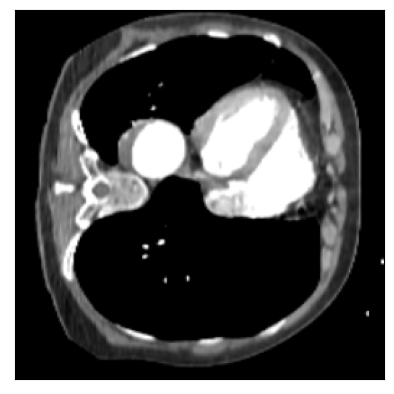

In [37]:
fileName = "Datasets/TotalSegmentator/TotalSegmentatorTesting.hdf5"
file = h5py.File(fileName)
print(len(file.keys()))

fig, ax = plt.subplots()

temp = []
for i, key in enumerate(file.keys()):
    #if np.amax(file[key]["Segmentation"]) == 2:
    if file[key].attrs["ImageLabel"] == 0:
        temp.append(key)

print(temp)

sliceGrp = file["Slice742"]
main = sliceGrp["Slice"]
segment = sliceGrp["Segmentation"]

contours = measure.find_contours(segment, 0.9)
#tumorContours = measure.find_contours(segment, 1.9)
#clamped = clamp(list(segment), 0, 1)
#ax.imshow(clamped)
ax.imshow(list(main), cmap=plt.cm.gray)

#contour = contours[0]
#tumContour = tumorContours[0]
#ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
#ax.plot(tumContour[:, 1], tumContour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()
#ax.imshow(list(pos), cmap=plt.cm.gray)
#ax.imshow(list(neg), cmap=plt.cm.gray)

In [ ]:
tumorCounter = 0
file = h5py.File("Datasets/MultiClass/MultiClassTestingDataset.hdf5")
for key in file.keys():
    tumorSegment = file[key]["TumorSegmentation"]

    if np.sum(tumorSegment) > 0:
        tumorCounter += 1

print(tumorCounter)